In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

from datetime import timedelta
import seaborn as sns

In [3]:
train_path = "train.csv"
test_path = "test.csv"
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
print(train.shape)
print(test.shape)

(1458644, 11)
(625134, 9)


In [8]:
#verification des valeurs dupliquées
print(train.duplicated().sum())
print(train.id.duplicated().sum())
print(test.id.duplicated().sum())

0
0
0


In [9]:
#assurer qu'il n'y a pas d'incoherance entre 
#les dates de depart et les dates d'arrivées 
sum(train.dropoff_datetime < train.pickup_datetime)

0

In [10]:
#CLEANING DATA

In [11]:
#cette variable est inutile car elle est non incluse dans test
train = train.drop("dropoff_datetime", 1)

In [12]:
#eliminer les valeurs dont la perode est tres longue
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.trip_duration.describe()

count   1458644.000
mean        959.492
std        5237.432
min           1.000
25%         397.000
50%         662.000
75%        1075.000
max     3526282.000
Name: trip_duration, dtype: float64

In [13]:
# voir les valeurs en heures
print(np.percentile(train.trip_duration, 99)/3600)
print(np.percentile(train.trip_duration, 99.5)/3600)
print(np.percentile(train.trip_duration, 99.6)/3600)
print(np.percentile(train.trip_duration, 99.8)/3600)
print(np.percentile(train.trip_duration, 99.856)/3600)
print(np.percentile(train.trip_duration, 99.9)/3600)
print(np.percentile(train.trip_duration, 99.99)/3600)
print(np.percentile(train.trip_duration, 99.999)/3600)
print(np.percentile(train.trip_duration, 99.9999)/3600)
print(train.trip_duration.max() / 3600)

0.9555555555555556
1.1497222222222223
1.2230555555555556
1.5421427777777554
3.2153868888880566
23.646765833333355
23.97972222222222
23.99138888888889
596.0994311441401
979.5227777777778


In [14]:
#on suppose qu'un vrais trajet ne depassera pas 3 heures
print("valeurs < 10h : ",len(train[train.trip_duration <= np.percentile(train.trip_duration, 99.856)]))
print("toute les valeurs : ", len(train.trip_duration))

valeurs < 10h :  1456543
toute les valeurs :  1458644


In [15]:
#supprimer les voyages qui prennent plus de 10 heures
train = train[train.trip_duration <= np.percentile(train.trip_duration, 99.856)]

In [16]:
# voir les valeurs en secondes
print(train.trip_duration.min())
print(np.percentile(train.trip_duration, 0.1))
print(np.percentile(train.trip_duration, 0.5))
print(np.percentile(train.trip_duration, 0.6))
print(np.percentile(train.trip_duration, 0.7))
print(np.percentile(train.trip_duration, 0.8))

1
7.0
50.0
60.0
69.0
75.0


In [17]:
#on suppose qu'un trajet ne soit pas inferieur à 15 secondes
print("valeurs > 15s : ",len(train[train.trip_duration >= np.percentile(train.trip_duration, 0.6)]))
print("toute les valeurs : ", len(train.trip_duration))

valeurs > 15s :  1447948
toute les valeurs :  1456543


In [18]:
#on les supprime
train = train[train.trip_duration >= np.percentile(train.trip_duration, 0.2)]

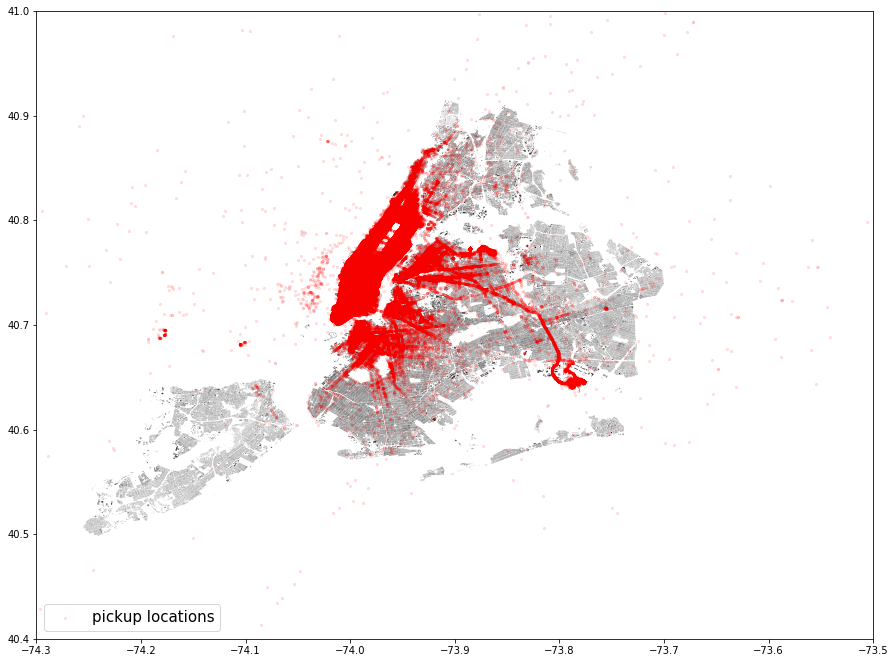

In [46]:
#distribution de données sur la carte 
nyc_map = gpd.read_file("nyc_roads.shp")

geometry = [Point(xy) for xy in zip(train["pickup_longitude"],train["pickup_latitude"])]
geo_train_data = gpd.GeoDataFrame(train, crs='EPSG:4326', geometry=geometry)

figure,ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, alpha=0.8, color="black")
geo_train_data.plot(ax=ax, markersize=20, color ="red", marker = ".", label = "pickup locations", alpha=0.1)
plt.xlim(-74.3,-73.5)
plt.ylim( 40.4,41)
plt.legend(prop={'size': 15})
plt.show()

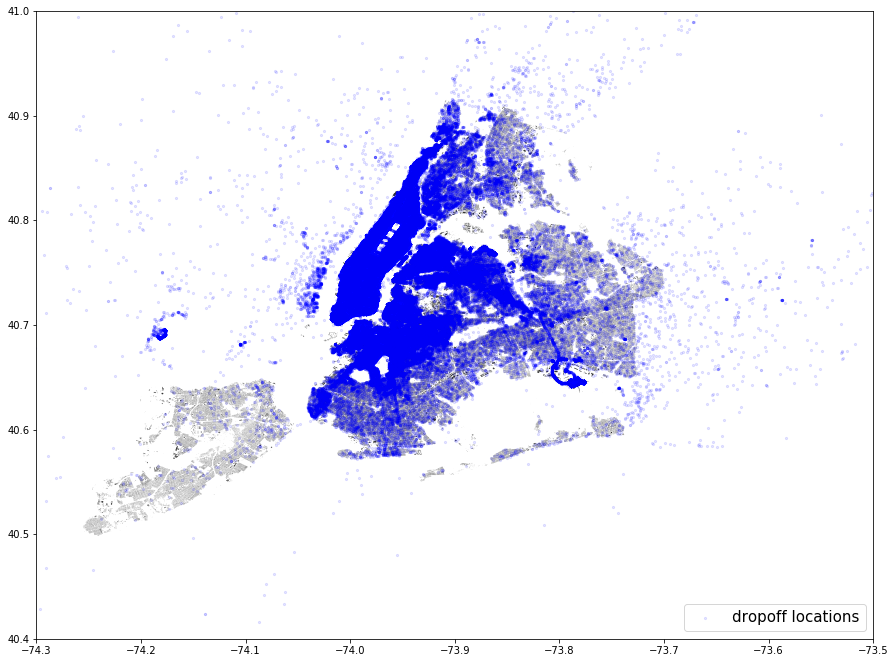

In [47]:
#distribution de données sur la carte 

geometry = [Point(xy) for xy in zip(train["dropoff_longitude"],train["dropoff_latitude"])]
geo_train_data = gpd.GeoDataFrame(train, crs='EPSG:4326', geometry=geometry)

figure,ax = plt.subplots(figsize=(15,15))
nyc_map.plot(ax=ax, alpha=0.8, color="black")
geo_train_data.plot(ax=ax, markersize=20, color ="blue", marker = ".", label = "dropoff locations", alpha=0.1)
plt.xlim(-74.3,-73.5)
plt.ylim( 40.4,41)
plt.legend(prop={'size': 15})
plt.show()

In [19]:
#examiner les valeurs 
print(train.pickup_latitude.max())
print(train.pickup_latitude.min())
print(train.pickup_longitude.max())
print(train.pickup_longitude.min())
print()
print(train.dropoff_latitude.max())
print(train.dropoff_latitude.min())
print(train.dropoff_longitude.max())
print(train.dropoff_longitude.min())

51.88108444213867
34.359695434570305
-61.33552932739258
-121.93334197998048

43.92102813720703
32.1811408996582
-61.33552932739258
-121.9333038330078


In [20]:
# Limiter la localisation
max_value = 99.999
min_value = 0.001

max_pickup_lat = np.percentile(train.pickup_latitude, max_value)
min_pickup_lat = np.percentile(train.pickup_latitude, min_value)
max_pickup_long = np.percentile(train.pickup_longitude, max_value)
min_pickup_long = np.percentile(train.pickup_longitude, min_value)

max_dropoff_lat = np.percentile(train.dropoff_latitude, max_value)
min_dropoff_lat = np.percentile(train.dropoff_latitude, min_value)
max_dropoff_long = np.percentile(train.dropoff_longitude, max_value)
min_dropoff_long = np.percentile(train.dropoff_longitude, min_value)

print(max_pickup_lat)
print(min_pickup_lat)
print(max_pickup_long)
print(min_pickup_long)
print()
print(max_dropoff_lat)
print(min_dropoff_lat)
print(max_dropoff_long)
print(min_dropoff_long)

41.29481268760649
39.21201828392029
-73.01560769883139
-74.9649441142273

41.38792255844105
38.92419767066956
-72.82020410294625
-77.03943634033203


In [21]:
#supprimer les localisation extremes
train = train[(train.pickup_latitude <= max_pickup_lat)
             & (train.pickup_latitude >= min_pickup_lat)]
train = train[(train.pickup_longitude <= max_pickup_long)
             & (train.pickup_longitude >= min_pickup_long)]

train = train[(train.dropoff_latitude <= max_dropoff_lat)
             & (train.dropoff_latitude >= min_dropoff_lat)]
train = train[(train.dropoff_longitude <= max_dropoff_long)
             & (train.dropoff_longitude >= min_dropoff_long)]

In [22]:
#concatener les dataset train et test
df = pd.concat([train,test], sort=False)

In [23]:
df.shape

(2078810, 10)

In [24]:
#convertir les date dans un format timestamp afin de faciliter la manipulation
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [25]:
#creer une variable minute
df["pickup_hour"] = df.pickup_datetime.dt.hour

In [26]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,1,-73.982,40.768,-73.965,40.766,N,455.000,17
1,id2377394,1,2016-06-12 00:43:35,1,-73.980,40.739,-73.999,40.731,N,663.000,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979,40.764,-74.005,40.710,N,2124.000,11
3,id3504673,2,2016-04-06 19:32:31,1,-74.010,40.720,-74.012,40.707,N,429.000,19
4,id2181028,2,2016-03-26 13:30:55,1,-73.973,40.793,-73.973,40.783,N,435.000,13


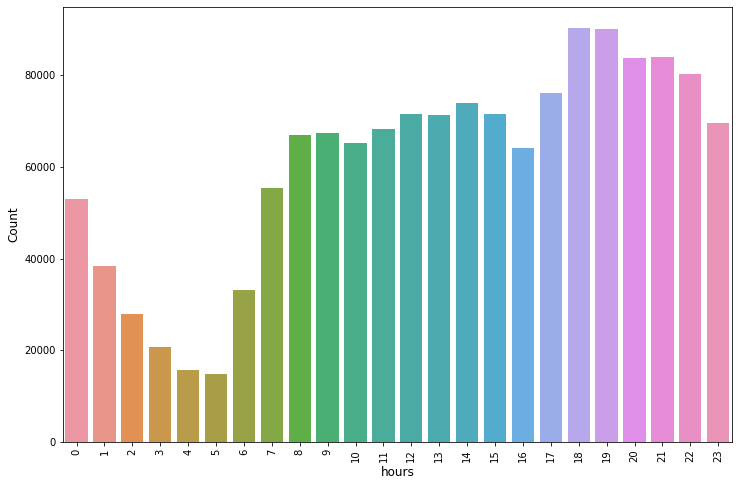

In [27]:
plt.figure(figsize=(12,8))
sns.countplot(x="pickup_hour", data=df[:-len(test)])
plt.ylabel('Count', fontsize=12)
plt.xlabel('hours', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [28]:
# charger les vacances et jours fériers aux états unies
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays()

# charger les jours ouvrables
us_bd = CustomBusinessDay(calendar = USFederalHolidayCalendar())
# faire correspondre ces jours avec nos données
business_days = pd.DatetimeIndex(start = df.pickup_datetime.min(), 
                                 end = df.pickup_datetime.max(), 
                                 freq = us_bd)
business_days = pd.to_datetime(business_days).date

C:\Users\Massinissa\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  # Remove the CWD from sys.path while we load stuff.


In [29]:
# creer differentes variables de temps
df['pickup_month'] = df.pickup_datetime.dt.month
df['pickup_weekday'] = df.pickup_datetime.dt.weekday
df['pickup_is_weekend'] = df.pickup_weekday.map(lambda x: 1 if x >= 5 else 0)
df['pickup_holiday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(holidays)
df['pickup_holiday'] = df.pickup_holiday.map(lambda x: 1 if x == True else 0)


df['pickup_businessday'] = pd.to_datetime(df.pickup_datetime.dt.date).isin(business_days)
df['pickup_businessday'] = df.pickup_businessday.map(lambda x: 1 if x == True else 0)

# Calcule la minute de la semaine
df['week_delta'] = (df.pickup_weekday + ((df.pickup_datetime.dt.hour + 
                                              (df.pickup_datetime.dt.minute / 60.0)) / 24.0))

In [30]:
# Déterminer le nombre de trajets qui se produisent à chaque heure spécifique

ride_counts = df.groupby(['pickup_month', 'pickup_weekday',
                          'pickup_holiday','pickup_businessday','pickup_hour']).size()
ride_counts = pd.DataFrame(ride_counts).reset_index()
ride_counts['ride_counts'] = ride_counts[0]
ride_counts = ride_counts.drop(0,1)

df = df.merge(ride_counts, on=['pickup_month',
                          'pickup_weekday',
                          'pickup_holiday',
                          'pickup_businessday',
                          'pickup_hour'], how='left')

In [31]:
#cette variable devient inutile
df = df.drop("pickup_datetime", 1)

In [33]:
# Réduir les emplacements de pickup et de dropoff à une seule valeur
pca = PCA(n_components=1)
df['pickup_pca'] = pca.fit_transform(df[['pickup_latitude','pickup_longitude']])
df['dropoff_pca'] = pca.fit_transform(df[['dropoff_latitude','dropoff_longitude']])

In [35]:
# Ajouter des variables distances
from pyproj import Geod
wgs84_geod = Geod(ellps='WGS84')

def Distance(lat1,lon1,lat2,lon2):
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
    return dist
#distance en metres
df['distance'] = Distance(df['pickup_latitude'].tolist(),
                          df['pickup_longitude'].tolist(),
                          df['dropoff_latitude'].tolist(),
                          df['dropoff_longitude'].tolist())

df['manhattan_distance'] = (abs(df.dropoff_longitude - df.pickup_longitude) +
                            abs(df.dropoff_latitude - df.pickup_latitude))

In [36]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [37]:
#calculer la direction 
df['direction'] = bearing_array(df['pickup_latitude'].values, 
                                df['pickup_longitude'].values, 
                                df['dropoff_latitude'].values, 
                                df['dropoff_longitude'].values)

In [38]:
# nous n'avonsplus besoin de cette variable
df = df.drop(["id"], 1)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078810 entries, 0 to 2078809
Data columns (total 21 columns):
vendor_id             int64
passenger_count       int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag    int64
trip_duration         float64
pickup_hour           int64
pickup_month          int64
pickup_weekday        int64
pickup_is_weekend     int64
pickup_holiday        int64
pickup_businessday    int64
week_delta            float64
ride_counts           int64
pickup_pca            float64
dropoff_pca           float64
distance              float64
manhattan_distance    float64
direction             float64
dtypes: float64(11), int64(10)
memory usage: 428.9 MB


In [44]:
# Renvoyer les données dans un ensemble de train et de test
trainFinal = df[:-len(test)]
testFinal = df[-len(test):]

In [77]:
# separer trip_duration de sa dataframe
# puisque c'est ce qu'on veut predir
# eliminez certaines variables sans importance
do_not_use_for_training = [ 'trip_duration','vendor_id', 'store_and_fwd_flag',
                           'pickup_is_weekend', 'passenger_count', 
                          'pickup_weekday', 'pickup_holiday', 'kmeans_dropoff_loc']
feature_names = [f for f in trainFinal.columns if f not in do_not_use_for_training]
print('We have %i features.' % len(feature_names))
y_train = np.log(trainFinal['trip_duration'].values + 1)
X_train = trainFinal[feature_names].values

X_test = testFinal[feature_names].values

We have 14 features.


In [86]:
#instancier un objet RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=70, criterion='mse', max_depth=35)

In [79]:
#X_train['store_and_fwd_flag'] = X_train.store_and_fwd_flag.map(lambda x: 1 if x == "Y" else 0)

In [87]:
model_rfr = rfr.fit(X_train, y_train)

In [90]:
print('RMSLE', mean_squared_log_error(y_train, rfr.predict(X_train))**0.5)

RMSLE 0.018701716851113104


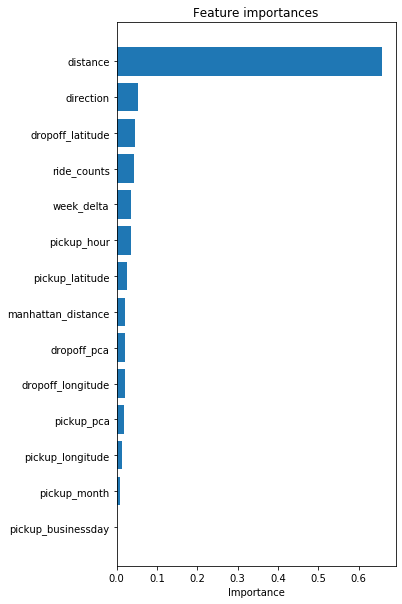

In [88]:
features_list = trainFinal[feature_names].columns.values
feature_importance = rfr.feature_importances_
sorted_idx = np.argsort(feature_importance)
 
plt.figure(figsize=(5,10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
plt.xlabel('Importance')
plt.title('Feature importances')
plt.draw()
plt.show()

In [89]:
#X_test['store_and_fwd_flag'] = X_test.store_and_fwd_flag.map(lambda x: 1 if x == "Y" else 0)

#Prediction
y_pred = model_rfr.predict(X_test)
# Enregistrer les resultat dans un fichier de submission
test['trip_duration'] = np.exp(y_pred) - 1
test.reset_index()[['id','trip_duration']].to_csv('submissionRFR.csv', index=False)